# Testing Notebook

In [1]:
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

In [2]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()

Using cache found in /home/ale/.cache/torch/hub/facebookresearch_dinov2_main
/home/ale/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/ale/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/ale/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affi

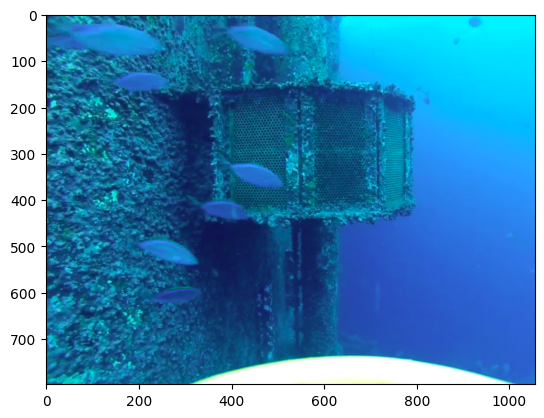

In [3]:
# Load and preprocess image
image = cv2.imread('./images/underwater.png')
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

import matplotlib.pyplot as plt
plt.imshow(image_rgb)

In [4]:
# DINOv2 preprocessing
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((518, 518)),  # DINOv2 works with 518x518 for vits14
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
img_tensor = transform(image_rgb).unsqueeze(0)  # Add batch dimension

In [6]:
# Extract features
with torch.no_grad():
    features = dinov2_vits14(img_tensor)  # Shape: [1, 384] (global features)
    
    # Get patch features (more interesting for visualization)
    patch_features = dinov2_vits14.forward_features(img_tensor)['x_norm_patchtokens']
    # Shape: [1, num_patches, feature_dim] = [1, 1369, 384] for 518x518 input

# Visualize patch features
num_patches = int(np.sqrt(patch_features.shape[1]))  # 37x37 for vits14
patch_h = patch_w = num_patches

# Reshape to spatial grid
features_map = patch_features[0].reshape(patch_h, patch_w, -1)

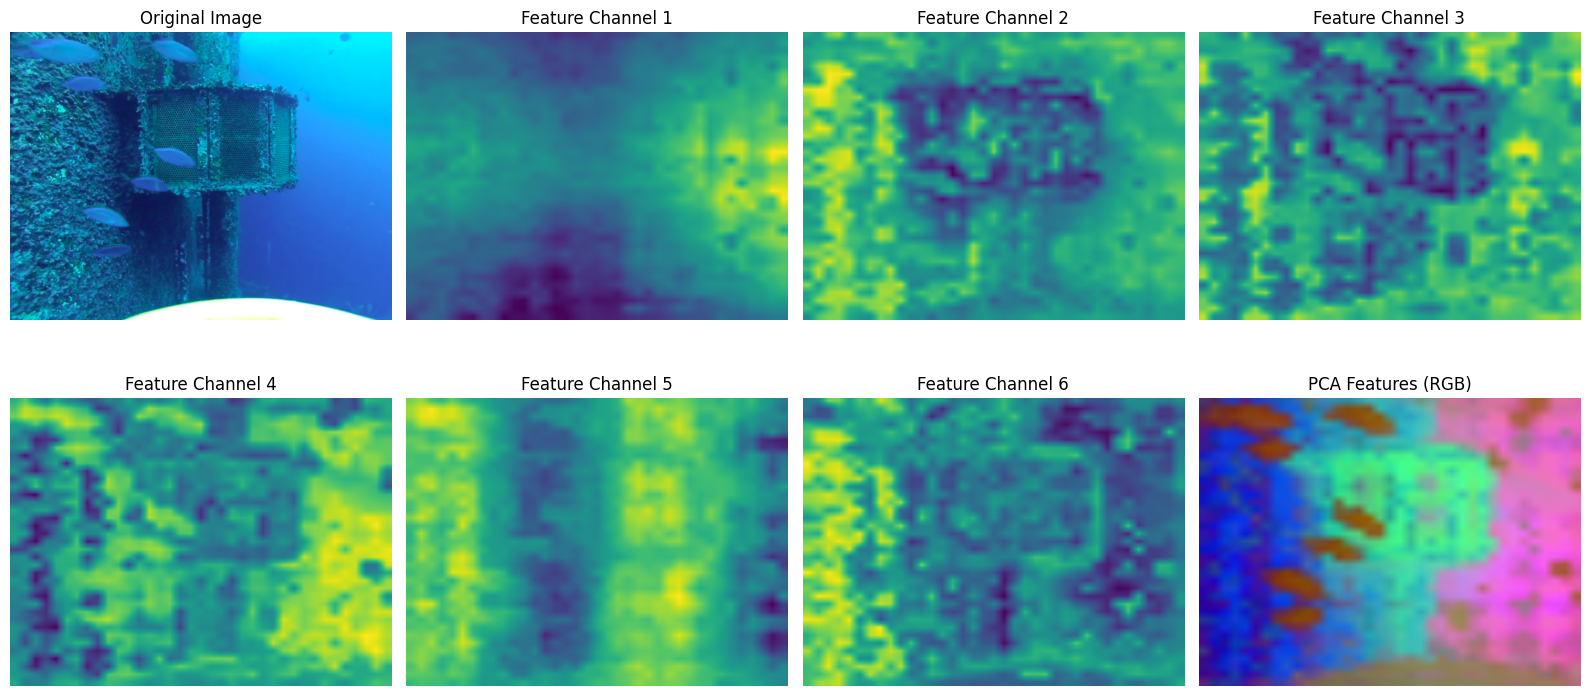

Global feature vector shape: torch.Size([1, 384])
Patch features shape: torch.Size([1, 1369, 384])
Feature map spatial size: 37x37
Feature dimension: 384


In [8]:
# Visualize first 6 feature dimensions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Original image
axes[0].imshow(image_rgb)
axes[0].set_title('Original Image')
axes[0].axis('off')

# Visualize different feature channels
for i in range(1, 7):
    feature_channel = features_map[:, :, i].cpu().numpy()
    # Resize to original image size for better visualization
    feature_resized = cv2.resize(feature_channel, (image_rgb.shape[1], image_rgb.shape[0]))
    axes[i].imshow(feature_resized, cmap='viridis')
    axes[i].set_title(f'Feature Channel {i}')
    axes[i].axis('off')

# PCA visualization (reduce 384 dims to 3 for RGB visualization)
from sklearn.decomposition import PCA

features_flat = features_map.reshape(-1, features_map.shape[-1]).cpu().numpy()
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_flat)

# Normalize to 0-1 for RGB display
features_pca = (features_pca - features_pca.min(axis=0)) / (features_pca.max(axis=0) - features_pca.min(axis=0))
features_pca_img = features_pca.reshape(patch_h, patch_w, 3)
features_pca_resized = cv2.resize(features_pca_img, (image_rgb.shape[1], image_rgb.shape[0]))

axes[7].imshow(features_pca_resized)
axes[7].set_title('PCA Features (RGB)')
axes[7].axis('off')

plt.tight_layout()
plt.show()

# Print feature statistics
print(f"Global feature vector shape: {features.shape}")
print(f"Patch features shape: {patch_features.shape}")
print(f"Feature map spatial size: {patch_h}x{patch_w}")
print(f"Feature dimension: {features_map.shape[-1]}")